# ЦИФРОВОЙ ПРОРЫВ 2022

# Чемпионат в Новосибирской области

## Классификация опор контактной сети и других объектов в массиве точек лазерных отражений для обеспечения безопасности движения железнодорожного транспорта

Российский железнодорожный комплекс — один из крупнейших в мире. Общая протяженность эксплуатационной длины железнодорожных
путей превышает 120 тысяч километров. В прошлом году в нашей стране поезда и электрички перевезли более 1 миллиарда пассажиров. Именно поэтому к проектированию и эксплуатации железнодорожной инфраструктуры предъявляются высокие требования по обеспечению
безопасности.

В связи с совершенствованием технологий геодезической съемки, инновационным решением при диагностике, строительстве и эксплуатации железнодорожных путей и придорожной инфраструктуры является построение цифровых моделей пути (ЦМП) на основе данных лазерного сканирования. 

Результат лазерного сканирования — это высокоточный массив точек лазерных отражений (ТЛО), на основе которого проводятся все необходимые измерения и последующий анализ данных. Определение опор контактной сети (ОКС) в массиве ТЛО — это одна из обязательных подзадач процесса определения габаритов приближения подвижного состава к ОКС.

В настоящий момент определение взаимного расположения объектов железнодорожной инфраструктуры происходит при натурном обследовании — в связи с чем высок риск получения недостоверной информации, что критично для обеспечения безопасности движения.

# Описание задачи


**Задача: создать решение по прогнозированию класса ТЛО с использованием параметров этой точки.**

Описание входных значений

файл **train.csv** — содержит данные для обучения модели:
- Параметр **id** — уникальный идентификатор ТЛО.
- Параметр **Easting** — направление на восток, условная координата Х
ТЛО в метрах
- Параметр **Northing** — направление на север, условная координата У
ТЛО в метрах
- Параметр **Height** — отметка (высота), условная координата Н ТЛО в
метрах
- Параметр **Reflectance** — отражательная способность ТЛО
- Параметр **Class** — признак класса точки

файл **test.csv** - содержит данные ТЛО для предсказания

файл **sample_solution.csv** — пример файла для отправки решения

Пояснение к данным
Столбец «Class»  хранит в себе тип класса точки, где:

- 0 – точки земли
- 1 – точки опор
- 3 – точки растительности
- 4 – точки рельсов
- 5 – точки элементов контактной сети
- 64 – точки шумов

**В качестве метрики выступает Recall по столбцу Class.**


# Этапы реализации:
1. Обзор и анализ предоставленных данных (Data analysis).
2. Масштабирование и формирование признаков (Preprocessing & Feature engineering). 
3. Минимизация влияния дисбаланса классов (Over-sampling).
4. Модель машинного обучения: алгоритм, обучение, кросс-валидация (Machine learning).
5. Формирование результата по тестовой выборке (Submit).
6. Как производилась валидация.
7. Выводы по работе с данными.

# 1. Data analysis

**Импортируем все, необходимые библиотеки и модули**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

pd.options.mode.chained_assignment = None
%matplotlib inline

**Загрузка данных в датафреймы (файлы должны быть расположены в директории данного решения, либо необходимо указать соответствующие пути к файлам)**

In [2]:
%%time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Wall time: 2.82 s


In [3]:
train.head(3) # смотрим первые записи 

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,431696.5375,6.032319e+06,69.2226,-11.14,0
1,3515173,431710.3835,6.032291e+06,68.9711,-15.16,3
2,2320295,431696.8099,6.032322e+06,69.2453,-13.59,0


In [4]:
train.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222094 entries, 0 to 4222093
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
 5   Class        int64  
dtypes: float64(4), int64(2)
memory usage: 193.3 MB


In [5]:
for column in train.columns:
    print(train[column].isna().sum()) # проверка на пропуски

0
0
0
0
0
0


In [6]:
train.duplicated().sum() # проверка на дубликаты

0

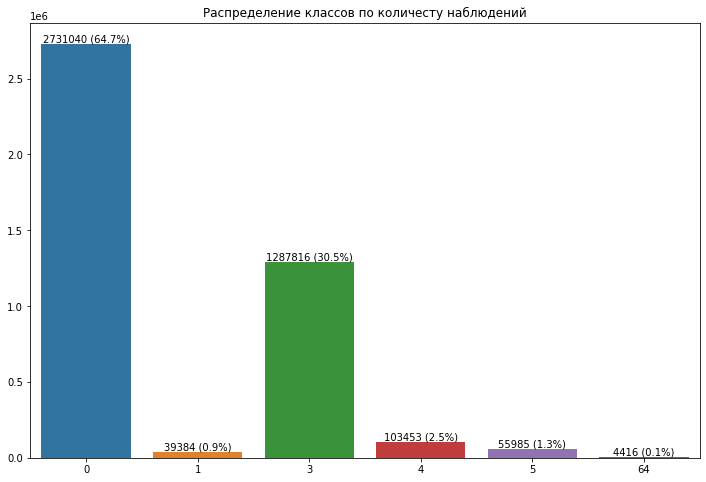

In [7]:
plt.subplots(figsize=(12, 8))
ax = sns.countplot(x=train['Class'])
df = pd.DataFrame(train['Class'].value_counts())
df['Norm'] = df.Class.map(lambda x: 100 * x / df.Class.sum())
df['Sort'] = df.index
df = df.sort_values(by='Sort')
abs_values = df['Class']
rel_values = df['Norm']
lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
plt.setp(ax, xlabel=None, ylabel=None, title='Распределение классов по количесту наблюдений')
plt.show()

In [8]:
test.head(3) # смотрим первые записи 

,id,Easting,Northing,Height,Reflectance
0,1836965,431754.6192,6.032265e+06,69.2608,-13.99
1,3659389,431654.4141,6.032344e+06,68.0129,-10.99
2,5433033,431686.8574,6.032334e+06,69.2442,-10.26


In [9]:
test.info() # смотрим общее описание

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809469 entries, 0 to 1809468
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
dtypes: float64(4), int64(1)
memory usage: 69.0 MB


In [10]:
for column in test.columns:
    print(test[column].isna().sum()) # проверка на пропуски

0
0
0
0
0


In [11]:
for column in ['Easting', 'Northing', 'Height', 'Reflectance']:
    print(f'Минимальное занчение параметра {column} в train: {train[column].min()}', f'Максимальное занчение параметра {column} в train: {train[column].max()}')
    print(f'Минимальное занчение параметра {column} в test: {test[column].min()}', f'Максимальное занчение параметра {column} в test: {test[column].max()}')

Минимальное занчение параметра Easting в train: 431629.442 Максимальное занчение параметра Easting в train: 431781.1712
Минимальное занчение параметра Easting в test: 431629.6401 Максимальное занчение параметра Easting в test: 431781.2418
Минимальное занчение параметра Northing в train: 6032231.7455 Максимальное занчение параметра Northing в train: 6032383.729
Минимальное занчение параметра Northing в test: 6032231.5173 Максимальное занчение параметра Northing в test: 6032383.6382
Минимальное занчение параметра Height в train: 60.4144 Максимальное занчение параметра Height в train: 133.7185
Минимальное занчение параметра Height в test: 60.5837 Максимальное занчение параметра Height в test: 115.8224
Минимальное занчение параметра Reflectance в train: -37.96 Максимальное занчение параметра Reflectance в train: 4.36
Минимальное занчение параметра Reflectance в test: -37.7 Максимальное занчение параметра Reflectance в test: 3.04


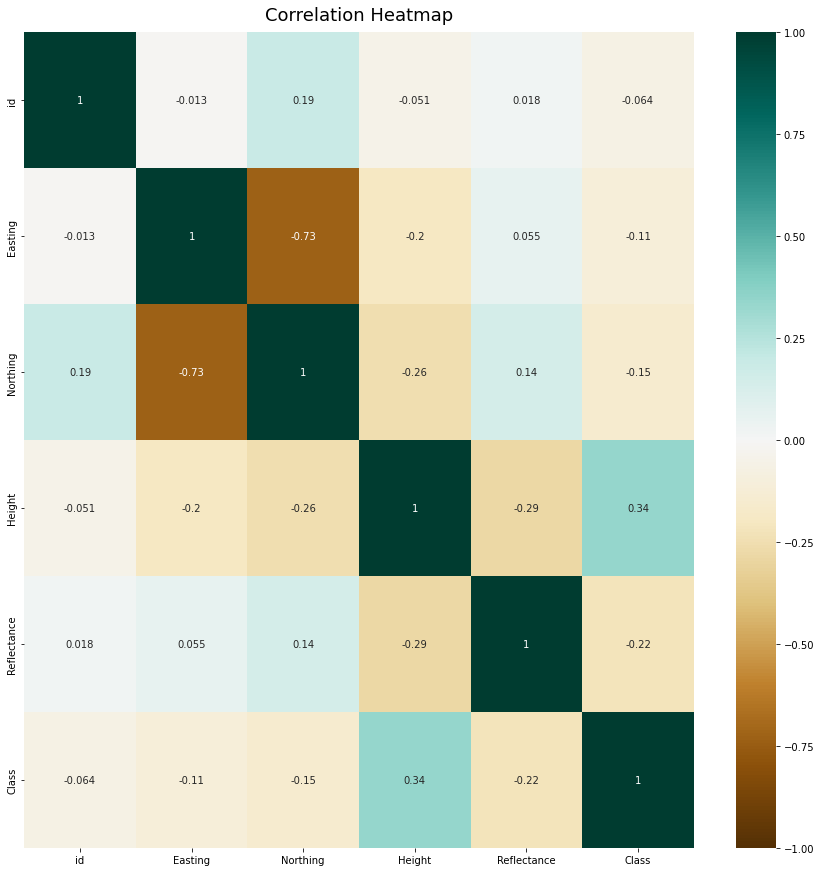

In [12]:
plt.rcParams['figure.figsize']=(15,15)
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

**Из обзора и анализа данных делаем три вывода**
1. Распределение значений в параметрах **Easting** и **Northing** позволяет взять в них остаток от деления на 1000 
2. Присутствует явный дисбаланс классов в обучающем наборе, который необходимо учесть при обучении модели
3. Между признаками наблюдаются достаточно значимые линейные, как положительные, так и отрицательные взаимосвязи

# 2. Preprocessing & Feature engineering

## 2.1. Параметр "Easting"

На основании выводов из обзора и анализа данных изменим данный параметр, взяв остаток от деления на 1000

In [13]:
train.Easting = train.Easting.map(lambda x: x % 1000) # изменяем параметр в train
test.Easting = test.Easting.map(lambda x: x % 1000) # изменяем параметр в test

## 2.2. Параметр "Northing"

На основании выводов из обзора и анализа данных изменим данный параметр, взяв остаток от деления на 1000

In [14]:
train.Northing = train.Northing.map(lambda x: x % 1000) # изменяем параметр в train
test.Northing = test.Northing.map(lambda x: x % 1000) # изменяем параметр в test

## 2.3. Параметр "Height"
Мы видим, что масштаб данного параметра меньше получившихся двух предыдущих параметров, было принято решение увеличить данный параметр в несколько раз, в результате при валидации, наилучший коэффициент для масштатбирования - 4. То есть "растягиваем" координату **Height** в четыре раза. 

In [15]:
train.Height = train.Height.map(lambda x: x * 4) # изменяем параметр в train
test.Height = test.Height.map(lambda x: x * 4) # изменяем параметр в test

**Так как выявлены достаточно значимые линейные взаимосвязи между имеющимися признаками, было принято решение рассмотреть добавление в данные новых признаков, являющихся различными линейными комбинациями из имеющихся. При валидации был определен эффект от добавления следующих двух признаков.**

## 2.4. Параметр S1 = "Easting" + "Northing"

In [16]:
train['S1'] = (train.Easting + train.Northing) # создаем параметр в train
test['S1'] = (test.Easting + test.Northing) # создаем параметр в test

## 2.5. Параметр S2 = "Easting" + "Northing"  + "Height"

In [17]:
train['S2'] = train.Easting  + train.Northing + train.Height # создаем параметр в train 
test['S2'] = test.Easting  + test.Northing + test.Height # создаем параметр в test

Параметр **Reflectance** оставим как есть

In [18]:
train.head(3) # смотрим первые записи 

,id,Easting,Northing,Height,Reflectance,Class,S1,S2
0,2321251,696.5375,319.4704,276.8904,-11.14,0,1016.0079,1292.8983
1,3515173,710.3835,290.6394,275.8844,-15.16,3,1001.0229,1276.9073
2,2320295,696.8099,322.4615,276.9812,-13.59,0,1019.2714,1296.2526


In [19]:
test.head(3) # смотрим первые записи 

,id,Easting,Northing,Height,Reflectance,S1,S2
0,1836965,754.6192,264.8129,277.0432,-13.99,1019.4321,1296.4753
1,3659389,654.4141,344.3676,272.0516,-10.99,998.7817,1270.8333
2,5433033,686.8574,333.6755,276.9768,-10.26,1020.5329,1297.5097


## 2.6. Выделим выборки

Переименуем класс 64 в класс 2 для дальнейшей работы, в итоге вернем классу 2 значение 64

In [20]:
X = train.drop(['Class', 'id'], axis = 1) 
y = train[['Class']]
y.Class = y.Class.map(lambda x: 2 if x == 64 else x)
y.Class.unique()

array([0, 3, 4, 5, 1, 2], dtype=int64)

In [21]:
X_test = test.drop(['id'], axis = 1)

# 3. Over-sampling (устранение дисбаланса классов)

Для устранение дисбаланса классов воспльзуемся **SMOTE** из библиотеки **imblearn**, этот алгоритм создает дополнительные синтетические наблюдения меньших классов.
1. По умолчанию все классы "выравниваются", в каждом меньшем классе создается доплнительное количество синтетических наблюдений, чтобы в итоге общее количество наблюдений класса равнялось количеству наблюдений максимального класса. 
2. В параметр sampling_strategy можно подать словарь, в котором сопоставить каждому классу необходимое количество итоговых наблюдений.
3. В нашем случае, при валидации было выявлено, что при полном "выпавнивании" классов избыточно формируются значения класса 3, поэтому было принято решение формировать меньшее количество синтетических наблюдений этого класса.
4. В результате итеративного процесса была выявлена оптимальная пропорция для наблюдений 3 класса - она равняется 67.5% от количества наблюдений наибольшего - нулевого класса.

In [22]:
%%time
N0 = int(y[y.Class==0].count()) # количество наблюдений наибольшего - нулевого класса
N3 = int(N0 * 0.675) # количество наблюдений для класса 3, равное 67.5% от оличество наблюдений наибольшего - нулевого класса
sampling_strategy={1: N0, 2: N0, 3: N3, 4: N0, 5: N0} # словарь для подачи в алгоритм SMOTE

smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, n_jobs=-1)  
X_res, y_res = smote.fit_resample(X, y) # процесс Over-sampling

Wall time: 50.3 s


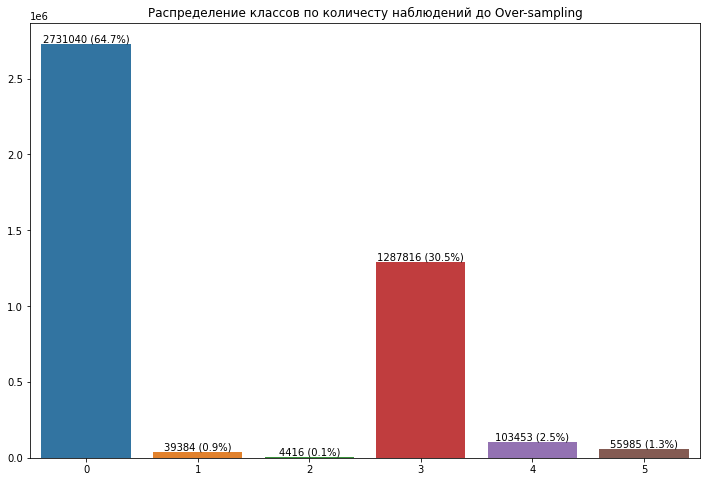

In [23]:
plt.subplots(figsize=(12, 8))
ax = sns.countplot(x=y['Class'])
df = pd.DataFrame(y['Class'].value_counts())
df['Norm'] = df.Class.map(lambda x: 100 * x / df.Class.sum())
df['Sort'] = df.index
df = df.sort_values(by='Sort')
abs_values = df['Class']
rel_values = df['Norm']
lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
plt.setp(ax, xlabel=None, ylabel=None, title='Распределение классов по количесту наблюдений до Over-sampling')
plt.show()

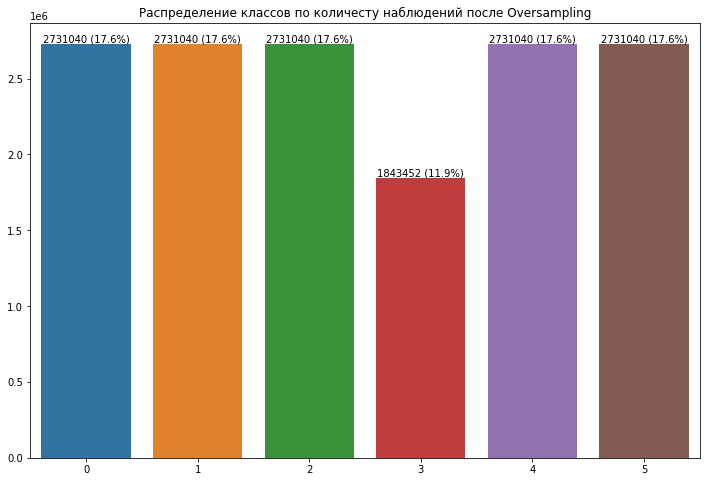

In [24]:
plt.subplots(figsize=(12, 8))
ax = sns.countplot(x=y_res['Class'])
df = pd.DataFrame(y_res['Class'].value_counts())
df['Norm'] = df.Class.map(lambda x: 100 * x / df.Class.sum())
df['Sort'] = df.index
df = df.sort_values(by='Sort')
abs_values = df['Class']
rel_values = df['Norm']
lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
plt.setp(ax, xlabel=None, ylabel=None, title='Распределение классов по количесту наблюдений после Oversampling')
plt.show()

# 4. Machine Learning
В целях выбора модели были рассмотрены градиентные бустинги: **CatBoost, XGBoost, LightGBM**. На валидации лучшие результаты показал **XGBoost** с гиперпараметрами:
- learning_rate = 0.2 (шаг обучения)
- n_estimators = 251 (количество деревьев)
- max_depth = 6 (максимальная глубина лерева)
- reg_lambda = 6 (коэффициент L2 - регуляризации)
- reg_alpha = 2 (коэффициент L1 - регуляризации)   

## 4.1. Обучение модели

In [25]:
XGBC = XGBClassifier(
                   learning_rate=0.2,
                   n_estimators=245,
                   max_depth=6,
                   objective="multi:softmax",
                   nthread=-1,
                   reg_lambda=6,
                   reg_alpha=2,
                   )

## Внимание !!! Следующая ячейка выполняется 2-3 часа в зависимости от CPU

In [26]:
%%time
XGBC.fit(X_res, y_res) # обучение модели

Wall time: 2h 19min 36s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=245,
              n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

<div class="alert alert-info">
Валидация модели производилась с использованием <b>MSI GeForce RTX 3060</b> при установлении в <b>XGBClassifier</b> двух дополнительных параметров: <b>predictor="gpu_predictor", tree_method="gpu_hist"</b>. При таких параметрах обучение производится за 1 минуту. Вместе с тем, без этих параметров обученная модель дает более точный прогноз (+ ~0.005 к метрике Recall).

## 4.2. Feature importance

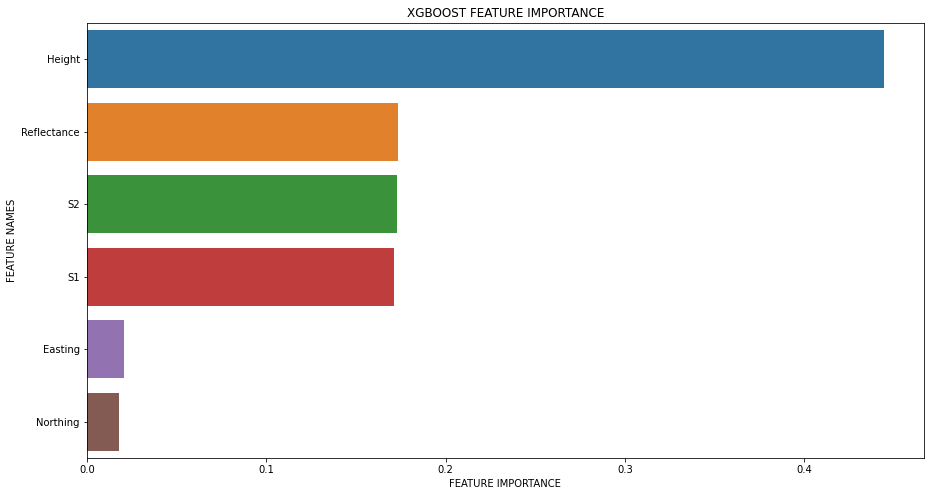

In [27]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,
          'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data) 
    fi_df.sort_values(by=['feature_importance'],    
                     ascending=False,inplace=True)
    plt.figure(figsize=(15,8))
    sns.barplot(x=fi_df['feature_importance'], 
               y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    
plot_feature_importance(XGBC.feature_importances_, X.columns,'XGBOOST')

# 5. Submit

## 5.1. Формирование результата

In [28]:
%%time
pred_test = XGBC.predict(X_test)
pred_test

Wall time: 19.6 s


array([0, 3, 0, ..., 0, 0, 3])

In [29]:
submit = pd.read_csv('sample_solution.csv')
submit['Class'] = pred_test
submit['Class'] = submit['Class'].astype('int32')
submit['Class'] = submit['Class'].map(lambda x: 64 if x == 2 else x) # возращаем классу 2 значение 64
submit.to_csv('submit_cbc.csv', index=False)

## 5.2. Распределение классов, имеющихся  в train и предсказанных в test

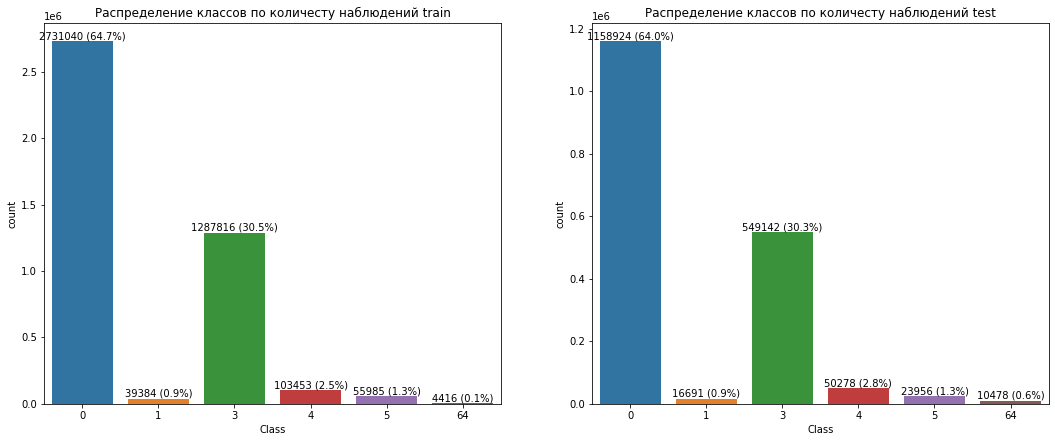

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax, tit in zip(axes, ['Распределение классов по количесту наблюдений train', 'Распределение классов по количесту наблюдений test']):    
    plt.setp(ax, xlabel=None, ylabel=None, title=tit)
for ax, tg in zip(axes, [train, submit]):
    sns.countplot(x=tg['Class'], ax=ax)
    df = pd.DataFrame(tg['Class'].value_counts())
    df['Norm'] = df.Class.map(lambda x: 100 * x / df.Class.sum())
    df['Sort'] = df.index
    df = df.sort_values(by='Sort')
    abs_values = df['Class']
    rel_values = df['Norm']
    lbls = [f'{p[0]} ({p[1]:.1f}%)' for p in zip(abs_values, rel_values)]
    ax.bar_label(container=ax.containers[0], labels=lbls)
plt.show()

# 5.3. Как обученная модель предсказывает саму обучающую выборку

In [31]:
%%time
y_pred = XGBC.predict(X)

Wall time: 45.5 s


In [32]:
recall_train = recall_score(y, y_pred, average='macro', zero_division=True)
print('Recall по предсказаниям на тренировочных данны:', recall_train)

Recall по предсказаниям на тренировочных данны: 0.9894399517268612


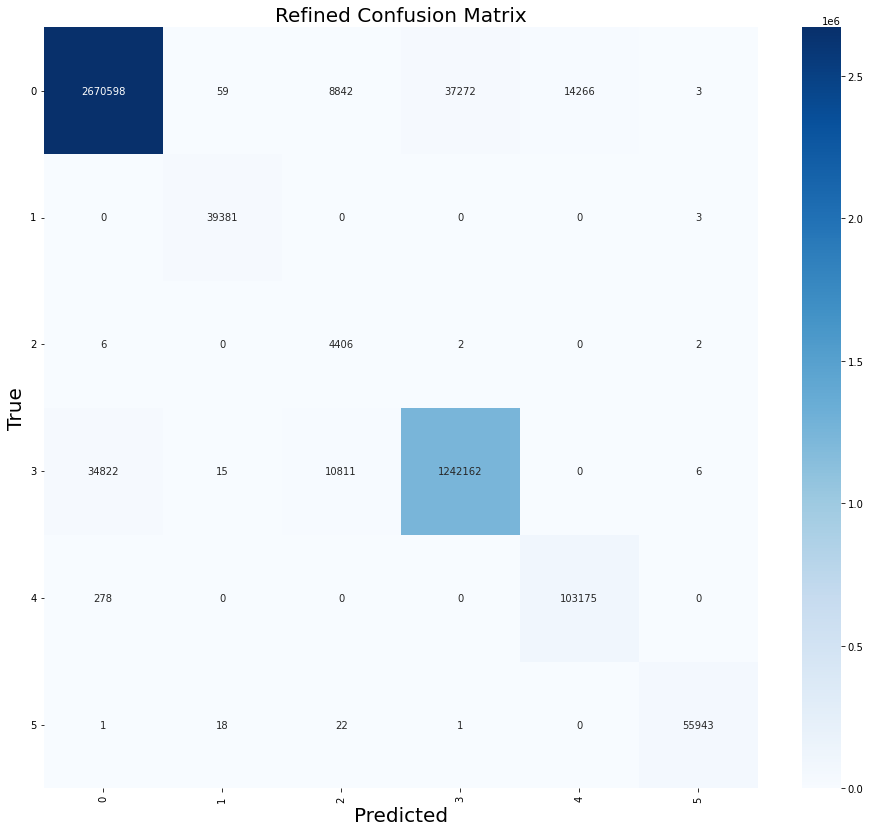

In [33]:
cm = confusion_matrix(y, y_pred)
class_names = sorted(y.Class.unique())
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize=10)
ax.xaxis.tick_bottom()
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize=10)
plt.yticks(rotation=0)
plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()

# 6. Как производилась валидация

<div class="alert alert-info">
Валидация модели производилась с использованием <b>MSI GeForce RTX 3060</b> при установлении в <b>XGBClassifier</b> двух дополнительных параметров: <b>predictor="gpu_predictor", tree_method="gpu_hist"</b>

## 6.1. Формирование выборок

Так как количство наблюдений в данных более 4 млн., а также в связи с ограниченными вычислительными ресурсами (автоматическая кросс-валидация в нашем случае оказалась невозможной) была сформирована единственная валидационная выборка для валидации модели. Мы посчитали это оптимальным решением.

In [34]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=12345)

Wall time: 20.5 s


Валидационная выборка не подвергается процедуре Over-sampling, а X_train и  y_train проходят через Over-sampling

## 6.2. Поиск оптимальной пропорции для наблюдений 3 класса

In [35]:
%%time
N0 = int(y_train[y_train.Class==0].count()) # количество наблюдений наибольшего - нулевого класса
best_recall = 0 
best_3 = 0

for i in tqdm(range(665, 680, 5)):
    smote = SMOTE(random_state=42, sampling_strategy={1: N0, 2: N0, 3: int(N0*i/1000), 4: N0, 5: N0}, n_jobs=-1) 
    X_res, y_res = smote.fit_resample(X_train, y_train)

    XGBC = XGBClassifier(
                   learning_rate=0.2,
                   n_estimators=251,
                   max_depth=6,
                   objective="multi:softmax",
                   nthread=-1,
                   reg_lambda=6,
                   alpha=2,
                   predictor="gpu_predictor",
                   tree_method="gpu_hist"
                   ) 

    XGBC.fit(X_res, y_res['Class'])
    pred_valid = XGBC.predict(X_valid)
    recall_valid = recall_score(y_valid, pred_valid, average='macro', zero_division=True)
    if recall_valid > best_recall:
        best_recall = recall_valid
        best_3 = i
    
print('best_recall:', best_recall)
print('N3:', round(best_3 / 1000, 3))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:31<00:00, 90.52s/it]

best_recall: 0.9760518850321972
N3: 0.67
Wall time: 4min 31s


## 6.3. Поиск гиперпараметров (на примере параметра "n_estimators")

In [36]:
%%time
smote = SMOTE(random_state=42, sampling_strategy={1: N0, 2: N0, 3: int(N0*0.675), 4: N0, 5: N0}, n_jobs=-1) 
X_res, y_res = smote.fit_resample(X_train, y_train)
best_recall = 0
n_est = 0
for i in tqdm(range(245, 255)):
    XGBC = XGBClassifier(
                   learning_rate=0.2,
                   n_estimators=i,
                   max_depth=6,
                   objective="multi:softmax",
                   nthread=-1,
                   reg_lambda=6,
                   alpha=2,
                   predictor="gpu_predictor",
                   tree_method="gpu_hist"
                   )
    XGBC.fit(X_res, y_res['Class'])
    pred_valid = XGBC.predict(X_valid)
    recall_valid = recall_score(y_valid, pred_valid, average='macro', zero_division=True)
    if recall_valid > best_recall:
        best_recall = recall_valid
        n_est = i
    
print('best_recall:', best_recall)
print('n_estimators', n_est)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:16<00:00, 55.64s/it]

best_recall: 0.9758697637963354
n_estimators 251
Wall time: 9min 51s


# 7. Выводы по результатм работы с данными

## 7.1. Определенное масштабирование данных значительно улучшает результат

## 7.2. Добавление признаков, являющихся линейными комбинациями исходных,  дает положительный эффект

## 7.3. Как бы не казалось странным, но исключение из признаков показателя «Reflectance» (отражательная способность ТЛО) лишь незначительно снижает результат!!! Это можно интерпретировать так:  рассматриваемые элементы железнодорожной инфраструктуры имеют стандартные размеры и располагаются друг относительно друга достаточно закономерно, поэтому во многом достаточно их точных координат.

## 7.4. По Refined Confusion Matrix из пункта 5.3. данного проекта мы видим, что класс 1 - точки опор контактной сети предсказывается практически на 100%. Основные неточности возникают между классами 0 - точки земли и 3 - точки растительности что не выглядит критично.